#### Experiment: Noisy Simulation, Several Cases

1. Molecule ($H_2$)
2. Fermi-Hubbard

In [1]:
import matplotlib.pyplot as plt
from fermihedral.fock import config_device

plt.style.use('classic')
plt.rc("font", size=28)

# uncomment this line to enable GPU support
# config_device("GPU")

In [2]:
%matplotlib inline

#### $H_2$

In [3]:
from dataclasses import dataclass
from typing import Literal
from fermihedral.fock import compile_molecule, configure_noise, get_eigenstates, run_qiskit_circuit
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper
from qiskit.quantum_info import Pauli
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class FermihedralMapper(FermionicMapper):
    SOLUTIONS = {8: ['_Z__Z_Z_', 'Z___Z_X_', '___ZYY__', '____X__X', '_Y__Z_Z_', '____X__Z', 'Y___Z_X_', 'X___Z_X_', '_X__Z_Z_', '__Y_X__Y', '__Z_X__Y', '___ZYZ__', '___ZYX__', '____Z_Y_', '___YY___', '___XY___'],
                 6: ['Z__Y__', 'Y____Y', 'Y____Z', 'Z__X__', 'Z__Z__', 'XZX___', 'XYX___', 'Y____X', 'X_Y_Y_', 'XXX___', 'X_Z___', 'X_Y_Z_'],
                 4: ['XZ_X', 'YZ_X', 'ZZZX', '_ZZY', 'ZZX_', 'Z_Y_', 'ZXXZ', 'ZYXZ'],
                 2: ['YX', 'XX', '_Z', '_Y'],
                 12: ['____Y____Z__', 'YY__X_______', 'Z___X__Y____', '____YX___X__', '__ZZZ_______', '__X_Z_X_____', 'YZ__X_______', '__Y_Z_____X_', '____YZ___X__', '__ZXZ_______', 'X___X______Y', 'X___X______X', '__Y_Z_____Z_', 'YX__X_______', '____Y___YY__', '____Y___XY__', '____Y___ZY__', '____YY___X__', '__Y_Z_____Y_', '__X_Z_Y_____', '__X_Z_Z_____', 'X___X______Z', '__ZYZ_______', 'Z___X__X____'],
                 10: ['_____XY__X', '___X_XZ___', '_____XY__Y', '_____XY__Z', '_____XX_X_', '_____XX_Y_', '_____Z_Z__', '_____XX_Z_', '___Y_XZ___', '___Z_XZ___', '_X__XY____', '_ZY__Y____', 'YY___Y____', 'ZY___Y____', '_ZX__Y____', '_ZZ__Y____', '_____Z_X__', '_____Z_Y__', '_X__YY____', 'XY___Y____']}

    @classmethod
    def get_solution(cls, nmodes: int):
        assert nmodes in cls.SOLUTIONS, f"undefined fermion-to-qubit mapping of {nmodes} modes"

        return [string.replace("_", "I") for string in cls.SOLUTIONS[nmodes]]

    @classmethod
    def pauli_table(
        cls, register_length: int, *, _: int | None = None
    ) -> list[tuple[Pauli, Pauli]]:
        solution = cls.get_solution(register_length)

        tables = []
        for j in range(register_length):
            tables.append((Pauli(solution[2 * j]), Pauli(solution[2 * j + 1])))

        return tables


bk = BravyiKitaevMapper()
fh = FermihedralMapper()
jw = JordanWignerMapper()


@dataclass
class SimulationData:
    error_q2: list[float]
    actual: list[float]
    estimate: list[float]
    variance: list[float]


def perform_simulation(molecule: Literal["H2", "LiH", "Li"], nshots: int, state: int = 0, *, prob1: float = 0.0001, prob2s: list = list(np.arange(0.0001, 0.01, 0.0001))):
    exp_result = {"BK": SimulationData([], [], [], []), "JW": SimulationData([],
                                                                             [], [], []), "Our Method": SimulationData([], [], [], [])}

    atom = {"H2": "H 0 0 0; H 0 0 0.735",
            "LiH": "Li 0.0 0.0 0.0; H 0.0 0.0 2.5", "Li": "Li 0 0 0"}[molecule]

    remove_orbits = {"H2": None, "LiH": [-3, -2], "Li": []}[molecule]

    for prob2 in tqdm(prob2s):
        for mapper, name in [(bk, "BK"), (jw, "JW"), (fh, "Our Method")]:
            circuit, observable, initial_energy = compile_molecule(
                atom, mapper, state, remove_orbits=remove_orbits, charge=(1 if molecule == "Li" else 0))

            configure_noise(prob1, prob2)

            estimation, variance = run_qiskit_circuit(
                circuit, observable, nshots)

            exp_result[name].error_q2.append(prob2)
            exp_result[name].actual.append(initial_energy)
            exp_result[name].estimate.append(estimation)
            exp_result[name].variance.append(variance)

    # save data
    with open(f"data/noisy-{molecule}-{state}.log", "w+") as log:
        for name in ("BK", "JW", "Our Method"):
            print(' '.join(map(str, exp_result[name].error_q2)), file=log)
            print(' '.join(map(str, exp_result[name].actual)), file=log)
            print(' '.join(map(str, exp_result[name].estimate)), file=log)
            print(' '.join(map(str, exp_result[name].variance)), file=log)


def perform_solving(molecule: Literal["H2", "LiH"]):
    atom = {"H2": "H 0 0 0; H 0 0 0.735",
            "LiH": "Li 0.0 0.0 0.0; H 0.0 0.0 1.6"}[molecule]
    with open(f"data/eigenstate-{molecule}.log", "w+") as log:
        for mapper, name in [(bk, "BK"), (jw, "JW"), (fh, "Our Method")]:
            eigenstates = get_eigenstates(atom, mapper)
            print(" ".join(map(str, eigenstates)), file=log)

for i in range(4):
    print(f">>>>> simulating with eigenstate {i} of H2")
    perform_simulation("H2", 3000, i)


>>>>> simulating with eigenstate 0 of H2


  0%|          | 0/99 [00:00<?, ?it/s]

BravyiKitaevMapper_H 0 0 0; H 0 0 0.735_0 not found solved result
> solved H 0 0 0; H 0 0 0.735, 0 state, BravyiKitaevMapper, E = -1.8572750302023797


/tmp/ipykernel_3945393/2538550583.py:67: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  estimation, variance = run_qiskit_circuit(


JordanWignerMapper_H 0 0 0; H 0 0 0.735_0 not found solved result
> solved H 0 0 0; H 0 0 0.735, 0 state, JordanWignerMapper, E = -1.8572750302023797
FermihedralMapper_H 0 0 0; H 0 0 0.735_0 not found solved result
> solved H 0 0 0; H 0 0 0.735, 0 state, FermihedralMapper, E = -1.8572750302023797


100%|██████████| 99/99 [00:54<00:00,  1.80it/s]


>>>>> simulating with eigenstate 1 of H2


  0%|          | 0/99 [00:00<?, ?it/s]

BravyiKitaevMapper_H 0 0 0; H 0 0 0.735_1 not found solved result
> solved H 0 0 0; H 0 0 0.735, 1 state, BravyiKitaevMapper, E = -1.244584549813327
JordanWignerMapper_H 0 0 0; H 0 0 0.735_1 not found solved result
> solved H 0 0 0; H 0 0 0.735, 1 state, JordanWignerMapper, E = -1.244584549813327
FermihedralMapper_H 0 0 0; H 0 0 0.735_1 not found solved result
> solved H 0 0 0; H 0 0 0.735, 1 state, FermihedralMapper, E = -1.244584549813327


100%|██████████| 99/99 [00:54<00:00,  1.82it/s]


>>>>> simulating with eigenstate 2 of H2


  0%|          | 0/99 [00:00<?, ?it/s]

BravyiKitaevMapper_H 0 0 0; H 0 0 0.735_2 not found solved result
> solved H 0 0 0; H 0 0 0.735, 2 state, BravyiKitaevMapper, E = -0.882722150244864
JordanWignerMapper_H 0 0 0; H 0 0 0.735_2 not found solved result
> solved H 0 0 0; H 0 0 0.735, 2 state, JordanWignerMapper, E = -0.882722150244864
FermihedralMapper_H 0 0 0; H 0 0 0.735_2 not found solved result
> solved H 0 0 0; H 0 0 0.735, 2 state, FermihedralMapper, E = -0.882722150244864


100%|██████████| 99/99 [00:54<00:00,  1.81it/s]


>>>>> simulating with eigenstate 3 of H2


  0%|          | 0/99 [00:00<?, ?it/s]

BravyiKitaevMapper_H 0 0 0; H 0 0 0.735_3 not found solved result
> solved H 0 0 0; H 0 0 0.735, 3 state, BravyiKitaevMapper, E = -0.22491125283086977
JordanWignerMapper_H 0 0 0; H 0 0 0.735_3 not found solved result
> solved H 0 0 0; H 0 0 0.735, 3 state, JordanWignerMapper, E = -0.22491125283086977
FermihedralMapper_H 0 0 0; H 0 0 0.735_3 not found solved result
> solved H 0 0 0; H 0 0 0.735, 3 state, FermihedralMapper, E = -0.22491125283086977


100%|██████████| 99/99 [00:57<00:00,  1.72it/s]


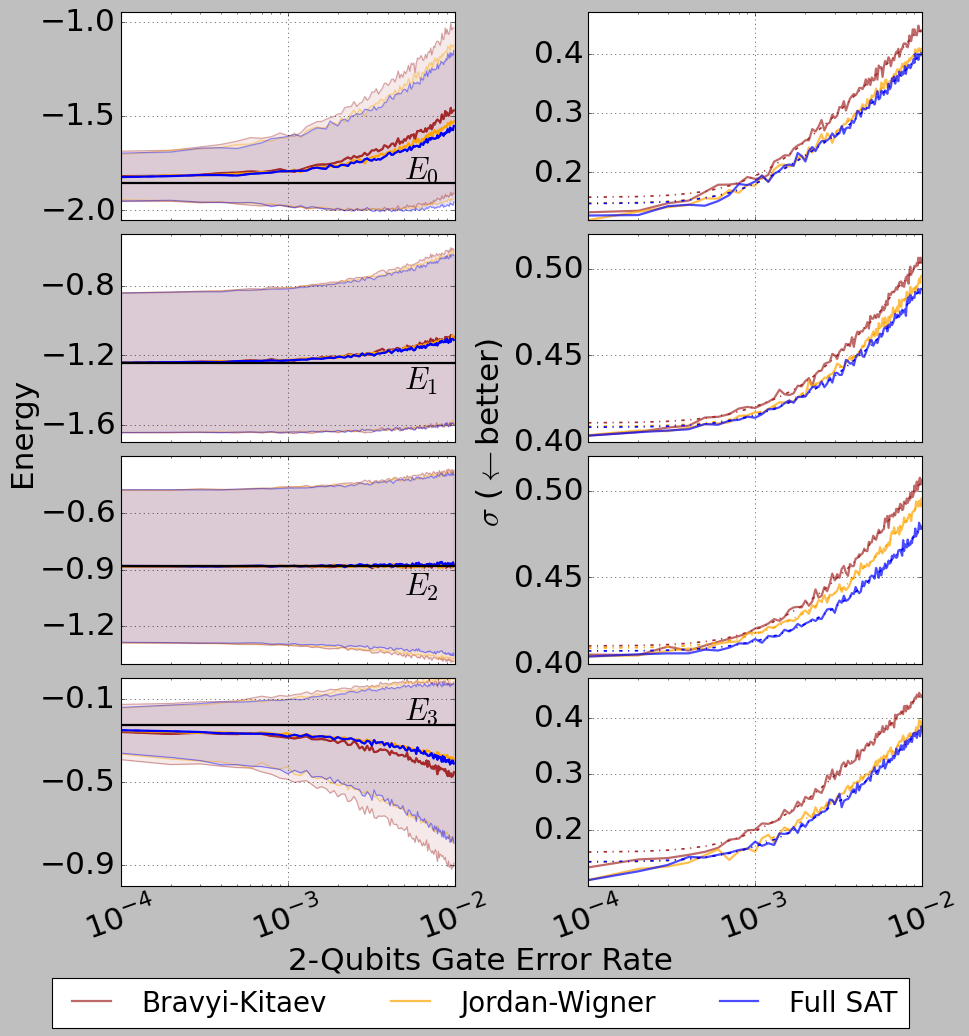

In [4]:
from scipy.ndimage import gaussian_filter1d

fig = plt.figure(figsize=(12, 13))
fig.subplots_adjust(left=0.125, right=0.96, top=0.99,
                    bottom=0.15, wspace=0.4, hspace=0.07)
fig_axis = fig.subplots(nrows=4, ncols=2, sharex=True)

bk_diffs = []
jw_diffs = []
fh_diffs = []

bk_vars = []
fh_vars = []

for eigenstate in range(4):
    bk = []
    jw = []
    fh = []

    with open(f"data/noisy-H2-{eigenstate}.log", "r") as log:
        lines = log.readlines()

        def read_line(lineno: int):
            return np.array(list(map(float, lines[lineno].strip().split(' '))))

        x = read_line(0)
        standard = read_line(1)
        bk_exp = read_line(2)
        bk_var = read_line(3)

        jw_exp = read_line(6)
        jw_var = read_line(7)

        fh_exp = read_line(10)
        fh_var = read_line(11)

    ax1, ax2 = fig_axis[eigenstate][0], fig_axis[eigenstate][1]

    def plot_with_variance(x, exp, var, label, color, *, sigma=1):
        low = exp - var
        high = exp + var

        ax1.plot(x, exp, color=color, linewidth=2, label=label)
        ax1.plot(x, exp,
                 linewidth=1.5, color=color, linestyle="--")
        ax1.fill_between(x, low, high, color=color, alpha=0.1)
        ax1.plot(x, low, color=color, linewidth=1, alpha=0.4)
        ax1.plot(x, high, color=color, linewidth=1, alpha=0.4)

    plot_with_variance(x, bk_exp, bk_var, "Bravyi-Kitaev", "brown")
    plot_with_variance(x, jw_exp, jw_var, "Jordan-Wigner", "orange")
    plot_with_variance(x, fh_exp, fh_var, "Full SAT", "blue")

    bk_diffs.extend(bk_exp - standard)
    jw_diffs.extend(jw_exp - standard)
    fh_diffs.extend(fh_exp - standard)

    bk_vars.extend(bk_var)
    fh_vars.extend(fh_var)

    std_value = standard[0]
    exp_value = bk_exp[-5]

    ax1.annotate(f"$E_{eigenstate}$", (0.005, std_value +
                 [0.03, -0.15, -0.15, 0.03][eigenstate]))

    ax1.plot(x, standard, color="black", linewidth=2)

    ax1.grid()
    ax1.set_xscale("log")
    ax1.tick_params(axis='x', labelrotation=20)

    ylims = [(-2.05, -0.95), (-1.7, -0.5), (-1.4, -0.3), (-1, 0)]
    yticks = [[-2.0, -1.5, -1.0], [-1.6, -1.2, -0.8],
              [-1.2, -0.9, -0.6], [-0.9, -0.5, -0.1]]

    ax1.set_ylim(ylims[eigenstate])
    ax1.set_yticks(yticks[eigenstate])

    if eigenstate == 1:
        ax1.set_ylabel("Energy")
        ax1.yaxis.set_label_coords(-0.25, 0.05)

    def plot_smooth(x, y, color, label):
        ax2.plot(x, y, color=color, linewidth=2, label=label, alpha=0.7)
        ax2.plot(x, gaussian_filter1d(y, 5),
                 linewidth=1.5, color=color, linestyle="-.")

    plot_smooth(x, bk_var, label="Bravyi-Kitaev", color="brown")
    plot_smooth(x, jw_var, label="Jordan-Wigner", color="orange")
    plot_smooth(x, fh_var, label="Full SAT", color="blue")
    ax2.grid()
    ax2.set_xscale("log")
    ax2.tick_params(axis='x', labelrotation=20)
    ylims = [(0.12, 0.47), (0.4, 0.52), (0.4, 0.52), (0.1, 0.47)]
    yticks = [[0.2, 0.3, 0.4], [0.4, 0.45, 0.5],
              [0.4, 0.45, 0.5], [0.2, 0.3, 0.4]]
    ax2.set_ylim(ylims[eigenstate])
    ax2.set_yticks(yticks[eigenstate])
    if eigenstate == 1:
        ax2.set_ylabel("$\sigma$ ($\leftarrow$better)")
        ax2.yaxis.set_label_coords(-0.25, 0.05)

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc="lower center",
           fontsize=25, ncol=3, bbox_to_anchor=(0.5, 0))
fig.supxlabel("2-Qubits Gate Error Rate", y=0.065)
fig.show()

#### Fermi-Hubbard

In [5]:
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.second_q.problems import LatticeModelProblem
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper
from qiskit_nature.second_q.hamiltonians.lattices import BoundaryCondition, SquareLattice
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit.quantum_info import Pauli
from fermihedral.fock import configure_noise, run_qiskit_circuit, compile_fermi_hubbard
from tqdm import tqdm
from dataclasses import dataclass
import numpy as np


class FermihedralMapper(FermionicMapper):
    SOLUTIONS = {6: ['__Y___', '__X___', 'ZZZYZZ', 'ZZZXZZ', 'Y_Z__Z',
                     'X_Z__Z', 'ZYZ_ZZ', 'ZXZ_ZZ', '__Z__Y', '__Z__X', 'Z_Z_YZ', 'Z_Z_XZ'],
                 8: ['_ZZ__YZ_', '_ZZ__XZ_', '_ZZ_YZZ_', '_ZZ_XZZ_', '_YZ___Z_', '_XZ___Z_', 'ZZZYZZZ_', 'ZZZXZZZ_', '__Y_____', '__X_____', 'YZZ_ZZZ_', 'XZZ_ZZZ_', '__Z___Y_', '__Z___X_', 'ZZZZZZZY', 'ZZZZZZZX']}

    @classmethod
    def get_solution(cls, nmodes: int):
        assert nmodes in cls.SOLUTIONS, f"undefined fermion-to-qubit mapping of {nmodes} modes"

        return [string.replace("_", "I") for string in cls.SOLUTIONS[nmodes]]

    @classmethod
    def pauli_table(
        cls, register_length: int, *, _: int | None = None
    ) -> list[tuple[Pauli, Pauli]]:
        solution = cls.get_solution(register_length)

        tables = []
        for j in range(register_length):
            tables.append((Pauli(solution[2 * j]), Pauli(solution[2 * j + 1])))

        return tables


bk = BravyiKitaevMapper()
fh = FermihedralMapper()
jw = JordanWignerMapper()


@dataclass
class SimulationData:
    error_q2: list[float]
    actual: list[float]
    estimate: list[float]
    variance: list[float]


def perform_simulation(nrows: int, ncols: int, nshots: int, *, prob1: float = 0.0001, prob2s: list = list(np.arange(0.0001, 0.01, 0.0001))):
    exp_result = {"BK": SimulationData([], [], [], []), "JW": SimulationData([],
                                                                             [], [], []), "Our Method": SimulationData([], [], [], [])}

    # fixed parameter
    boundary_condition = BoundaryCondition.PERIODIC
    t = -1.0
    v = 0.0
    u = 5.0

    square_lattice = SquareLattice(
        rows=nrows, cols=ncols, boundary_condition=boundary_condition)
    fhm = FermiHubbardModel(
        square_lattice.uniform_parameters(
            uniform_interaction=t,
            uniform_onsite_potential=v,
        ),
        onsite_interaction=u,
    )

    for mapper, name in [(bk, "BK"), (jw, "JW"), (fh, "Our Method")]:
        circuit, observable, initial_energy = compile_fermi_hubbard(LatticeModelProblem(
            fhm), mapper)
        for prob2 in tqdm(prob2s):
            configure_noise(prob1, prob2)

            estimation, variance = run_qiskit_circuit(
                circuit, observable, nshots)

            exp_result[name].error_q2.append(prob2)
            exp_result[name].actual.append(initial_energy)
            exp_result[name].estimate.append(estimation)
            exp_result[name].variance.append(variance)

    # save data
    with open(f"data/noisy-fermi-hubbard-{nrows}-{ncols}.log", "w+") as log:
        for name in ("BK", "JW", "Our Method"):
            print(' '.join(map(str, exp_result[name].error_q2)), file=log)
            print(' '.join(map(str, exp_result[name].actual)), file=log)
            print(' '.join(map(str, exp_result[name].estimate)), file=log)
            print(' '.join(map(str, exp_result[name].variance)), file=log)


perform_simulation(2, 2, 1000)
perform_simulation(3, 1, 500)

8
BravyiKitaevMapper not found solved result
> solved fermi hubbard, ground state, BravyiKitaevMapper, E = -3.347890419346535


  0%|          | 0/99 [00:00<?, ?it/s]/tmp/ipykernel_4180270/3529707156.py:76: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  estimation, variance = run_qiskit_circuit(
100%|██████████| 99/99 [02:29<00:00,  1.51s/it]


8
JordanWignerMapper not found solved result
> solved fermi hubbard, ground state, JordanWignerMapper, E = -3.3478904193465384


100%|██████████| 99/99 [02:20<00:00,  1.42s/it]


8
FermihedralMapper not found solved result
> solved fermi hubbard, ground state, FermihedralMapper, E = -3.347890419346541


100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


6
BravyiKitaevMapper not found solved result
> solved fermi hubbard, ground state, BravyiKitaevMapper, E = -3.0000000000000107


100%|██████████| 99/99 [00:38<00:00,  2.58it/s]


6
JordanWignerMapper not found solved result
> solved fermi hubbard, ground state, JordanWignerMapper, E = -3.0000000000000018


100%|██████████| 99/99 [00:35<00:00,  2.83it/s]


6
FermihedralMapper not found solved result
> solved fermi hubbard, ground state, FermihedralMapper, E = -2.9999999999999982


100%|██████████| 99/99 [00:25<00:00,  3.89it/s]


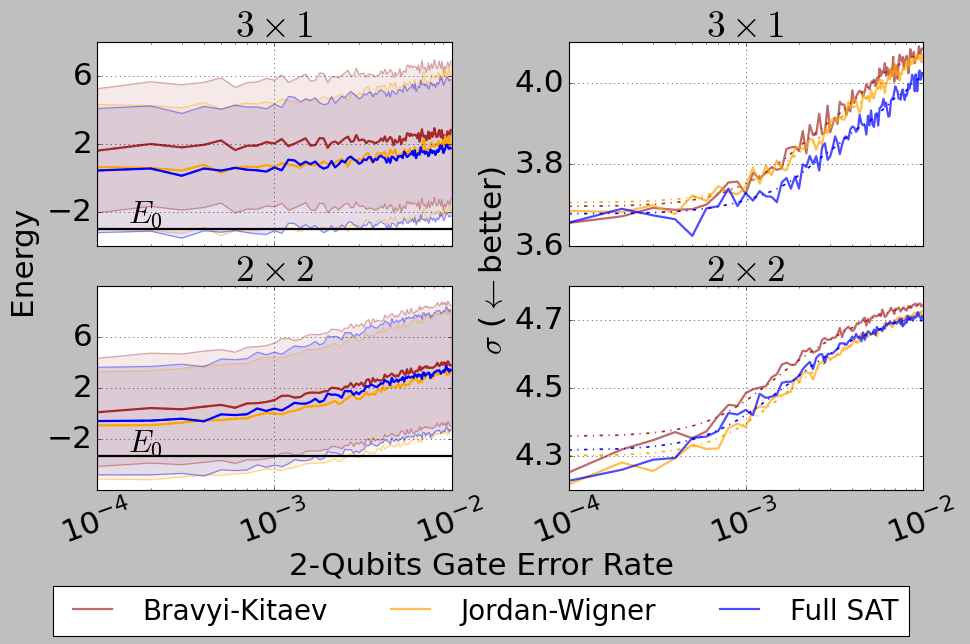

In [8]:
# plot

from scipy.ndimage import gaussian_filter1d

def plot_fermi_hubbard(*pairs: tuple[int, int]):
    fig = plt.figure(figsize=(12, 8))
    fig.subplots_adjust(left=0.1, right=0.96, top=0.95,
                        bottom=0.25, wspace=0.33, hspace=0.2)

    axis_all = fig.subplots(nrows=len(pairs), ncols=2, sharex=True)

    for id, (nrows, ncols) in enumerate(pairs):

        figure_axis = axis_all[id]
        ax1 = figure_axis[0]
        ax2 = figure_axis[1]

        with open(f"data/noisy-fermi-hubbard-{nrows}-{ncols}.log", "r") as log:
            lines = log.readlines()

            def read_line(lineno: int):
                return np.array(list(map(float, lines[lineno].strip().split(' '))))

            x = read_line(0)
            standard = read_line(1)
            bk_exp = read_line(2)
            bk_var = read_line(3)

            jw_exp = read_line(6)
            jw_var = read_line(7)

            fh_exp = read_line(10)
            fh_var = read_line(11)

        def plot_with_variance(x, exp, var, label, color, *, sigma=1):
            low = exp - var
            high = exp + var

            ax1.plot(x, exp, color=color, linewidth=2, label=label)
            ax1.plot(x, exp,
                     linewidth=1.5, color=color, linestyle="--")
            ax1.fill_between(x, low, high, color=color, alpha=0.1)
            ax1.plot(x, low, color=color, linewidth=1, alpha=0.4)
            ax1.plot(x, high, color=color, linewidth=1, alpha=0.4)

        plot_with_variance(x, bk_exp, bk_var, "Bravyi-Kitaev", "brown")
        plot_with_variance(x, jw_exp, jw_var, "Jordan-Wigner", "orange")
        plot_with_variance(x, fh_exp, fh_var, "Our Method", "blue")

        std_value = standard[0]

        ax1.annotate(f"$E_0$", (1.5 * 10e-5, std_value + 0.4))

        ax1.set_title(f"${nrows}\\times{ncols}$")
        ax2.set_title(f"${nrows}\\times{ncols}$")

        ax1.plot(x, standard, color="black", linewidth=2)

        ax1.grid()
        ax1.set_xscale("log")
        ax1.tick_params(axis='x', labelrotation=20)
        # ax1.set_ylim(ylims[eigenstate])
        ax1.set_yticks([-2, 2, 6])

        if id == 0:
            ax1.set_ylabel("Energy")
            ax1.yaxis.set_label_coords(-0.17, -0.07)

        def plot_smooth(x, y, color, label):
            ax2.plot(x, y, color=color, linewidth=2, label=label, alpha=0.7)
            ax2.plot(x, gaussian_filter1d(y, 5),
                     linewidth=1.5, color=color, linestyle="-.")

        plot_smooth(x, bk_var, label="Bravyi-Kitaev", color="brown")
        plot_smooth(x, jw_var, label="Jordan-Wigner", color="orange")
        plot_smooth(x, fh_var, label="Full SAT", color="blue")
        ax2.grid()
        ax2.set_xscale("log")
        ax2.tick_params(axis='x', labelrotation=20)
        # ax2.set_ylim(ylims[eigenstate])

        yticks = {(3, 1): [3.6, 3.8, 4.0], (2, 2): [4.3, 4.5, 4.7]}

        ax2.set_yticks(yticks[(nrows, ncols)])
        if id == 0:
            ax2.set_ylabel("$\sigma$ ($\leftarrow$better)")
            ax2.yaxis.set_label_coords(-0.17, -0.07)

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc="lower center",
               fontsize=25, ncol=3, bbox_to_anchor=(0.5, 0))
    fig.supxlabel("2-Qubits Gate Error Rate", y=0.11)
    fig.show()


plot_fermi_hubbard((3, 1), (2, 2))

#### Ionq

You need to rerun the $H_2$ simulation on Ionq Aria-1/2 or Harmony and copy the result here. It takes around $500 to run the experiment on the quantum computer.

<Figure size 640x480 with 0 Axes>

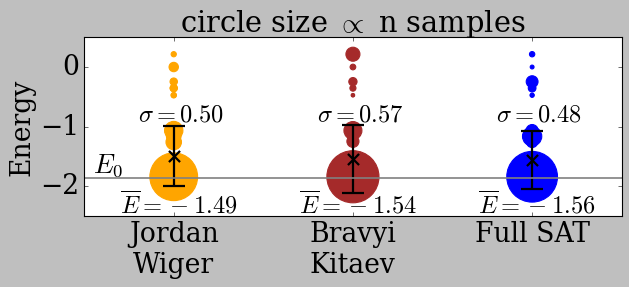

In [9]:
from qiskit.quantum_info import Statevector
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper
from math import sqrt
from qiskit.quantum_info import Pauli
from statistics import mean, variance
import numpy as np

import matplotlib.pyplot as plt

plt.style.use("classic")
plt.rc("font", size=24, family="serif")

BASELINE = -1.8572750302023797

JORDAN_WIGNER = {"0000": 0.023666666666666666,
                 "1000": 0.02,
                 "0100": 0.008,
                 "1100": 0.007333333333333333,
                 "0010": 0.06466666666666666,
                 "1010": 0.615,
                 "0110": 0.04466666666666667,
                 "1110": 0.04033333333333333,
                 "0001": 0.006333333333333333,
                 "1001": 0.04633333333333333,
                 "0101": 0.014666666666666666,
                 "1101": 0.014333333333333333,
                 "0011": 0.017,
                 "1011": 0.057,
                 "0111": 0.013333333333333334,
                 "1111": 0.007333333333333333}

BRAVYI_KITAEV = {"0000": 0.008666666666666666,
                 "1000": 0.010666666666666666,
                 "0100": 0.018333333333333333,
                 "1100": 0.03833333333333333,
                 "0010": 0.028666666666666667,
                 "1010": 0.053,
                 "0110": 0.049,
                 "1110": 0.7333333333333333,
                 "0001": 0.0033333333333333335,
                 "1001": 0.0003333333333333333,
                 "0101": 0.0023333333333333335,
                 "1101": 0.010333333333333333,
                 "0011": 0.005333333333333333,
                 "1011": 0.002,
                 "0111": 0.01,
                 "1111": 0.026333333333333334}

FERMIHEDRAL = {"0000": 0.004,
               "1000": 0.0033333333333333335,
               "0100": 0.01633333333333333,
               "1100": 0.024,
               "0010": 0.002,
               "1010": 0.008,
               "0110": 0.004666666666666667,
               "1110": 0.03766666666666667,
               "0001": 0.028666666666666667,
               "1001": 0.033,
               "0101": 0.10033333333333333,
               "1101": 0.6943333333333334,
               "0011": 0.007666666666666666,
               "1011": 0.004666666666666667,
               "0111": 0.016,
               "1111": 0.015333333333333332}


class FermihedralMapper(FermionicMapper):
    SOLUTIONS = {8: ['_Z__Z_Z_', 'Z___Z_X_', '___ZYY__', '____X__X', '_Y__Z_Z_', '____X__Z', 'Y___Z_X_', 'X___Z_X_', '_X__Z_Z_', '__Y_X__Y', '__Z_X__Y', '___ZYZ__', '___ZYX__', '____Z_Y_', '___YY___', '___XY___'],
                 6: ['Z__Y__', 'Y____Y', 'Y____Z', 'Z__X__', 'Z__Z__', 'XZX___', 'XYX___', 'Y____X', 'X_Y_Y_', 'XXX___', 'X_Z___', 'X_Y_Z_'],
                 4: ['XZ_X', 'YZ_X', 'ZZZX', '_ZZY', 'ZZX_', 'Z_Y_', 'ZXXZ', 'ZYXZ'],
                 2: ['YX', 'XX', '_Z', '_Y'],
                 12: ['____Y____Z__', 'YY__X_______', 'Z___X__Y____', '____YX___X__', '__ZZZ_______', '__X_Z_X_____', 'YZ__X_______', '__Y_Z_____X_', '____YZ___X__', '__ZXZ_______', 'X___X______Y', 'X___X______X', '__Y_Z_____Z_', 'YX__X_______', '____Y___YY__', '____Y___XY__', '____Y___ZY__', '____YY___X__', '__Y_Z_____Y_', '__X_Z_Y_____', '__X_Z_Z_____', 'X___X______Z', '__ZYZ_______', 'Z___X__X____'],
                 10: ['_____XY__X', '___X_XZ___', '_____XY__Y', '_____XY__Z', '_____XX_X_', '_____XX_Y_', '_____Z_Z__', '_____XX_Z_', '___Y_XZ___', '___Z_XZ___', '_X__XY____', '_ZY__Y____', 'YY___Y____', 'ZY___Y____', '_ZX__Y____', '_ZZ__Y____', '_____Z_X__', '_____Z_Y__', '_X__YY____', 'XY___Y____']}

    @classmethod
    def get_solution(cls, nmodes: int):
        assert nmodes in cls.SOLUTIONS, f"undefined fermion-to-qubit mapping of {nmodes} modes"

        return [string.replace("_", "I") for string in cls.SOLUTIONS[nmodes]]

    @classmethod
    def pauli_table(
        cls, register_length: int, *, _: int | None = None
    ) -> list[tuple[Pauli, Pauli]]:
        solution = cls.get_solution(register_length)

        tables = []
        for j in range(register_length):
            tables.append((Pauli(solution[2 * j]), Pauli(solution[2 * j + 1])))

        return tables


def process(data: dict[str, float], mapper: FermionicMapper):
    problem = PySCFDriver("H 0 0 0; H 0 0 0.735").run()

    hamiltonian = mapper.map(problem.hamiltonian.second_q_op())

    energies = []

    for state, prob in data.items():
        initial_state = Statevector.from_label(state[::-1])
        exp_energy = initial_state.expectation_value(hamiltonian)

        n = round(prob * 3000)

        for _ in range(n):
            energies.append(exp_energy.real)

    return mean(energies), sqrt(variance(energies)), np.unique(energies, return_counts=True)


plt.clf()
plt.figure(figsize=(8, 3.5))
plt.subplots_adjust(left=0.13, right=0.97, top=0.88, bottom=0.24)


def plot(data, mapper, id):
    COLOR = ["orange", "brown", "blue"][id - 1]

    exp, var, (samples, counts) = process(data, mapper)
    plt.scatter([id] * len(samples), samples, s=counts, color=COLOR)
    plt.scatter([id], [exp], s=[100], marker="x",
                color="black", linewidths=2)
    plt.errorbar([id], [exp], [var], color="black",
                 elinewidth=2, capsize=10, capthick=2)
    plt.annotate(f"$\sigma={var:.2f}$", (id - 0.2, -0.9), fontsize=22)
    plt.annotate(f"$\overline{{E}}={exp:.2f}$", (id - 0.3, -2.45), fontsize=22)


plot(JORDAN_WIGNER, JordanWignerMapper(), 1)
plot(BRAVYI_KITAEV, BravyiKitaevMapper(), 2)
plot(FERMIHEDRAL, FermihedralMapper(), 3)

plt.plot([0, 1, 2, 3, 4], [BASELINE, BASELINE,
         BASELINE, BASELINE, BASELINE], color="gray", linewidth=1.5)
plt.annotate("$E_0$", (0.55, BASELINE + 0.1))

plt.xlim(0.5, 3.5)
plt.xticks([1, 2, 3], ["Jordan\nWiger", "Bravyi\nKitaev", "Full SAT"])
plt.title("circle size $\propto$ n samples", fontsize=26)
plt.ylabel("Energy")
plt.yticks([-2.0, -1.0,  0])
plt.show()